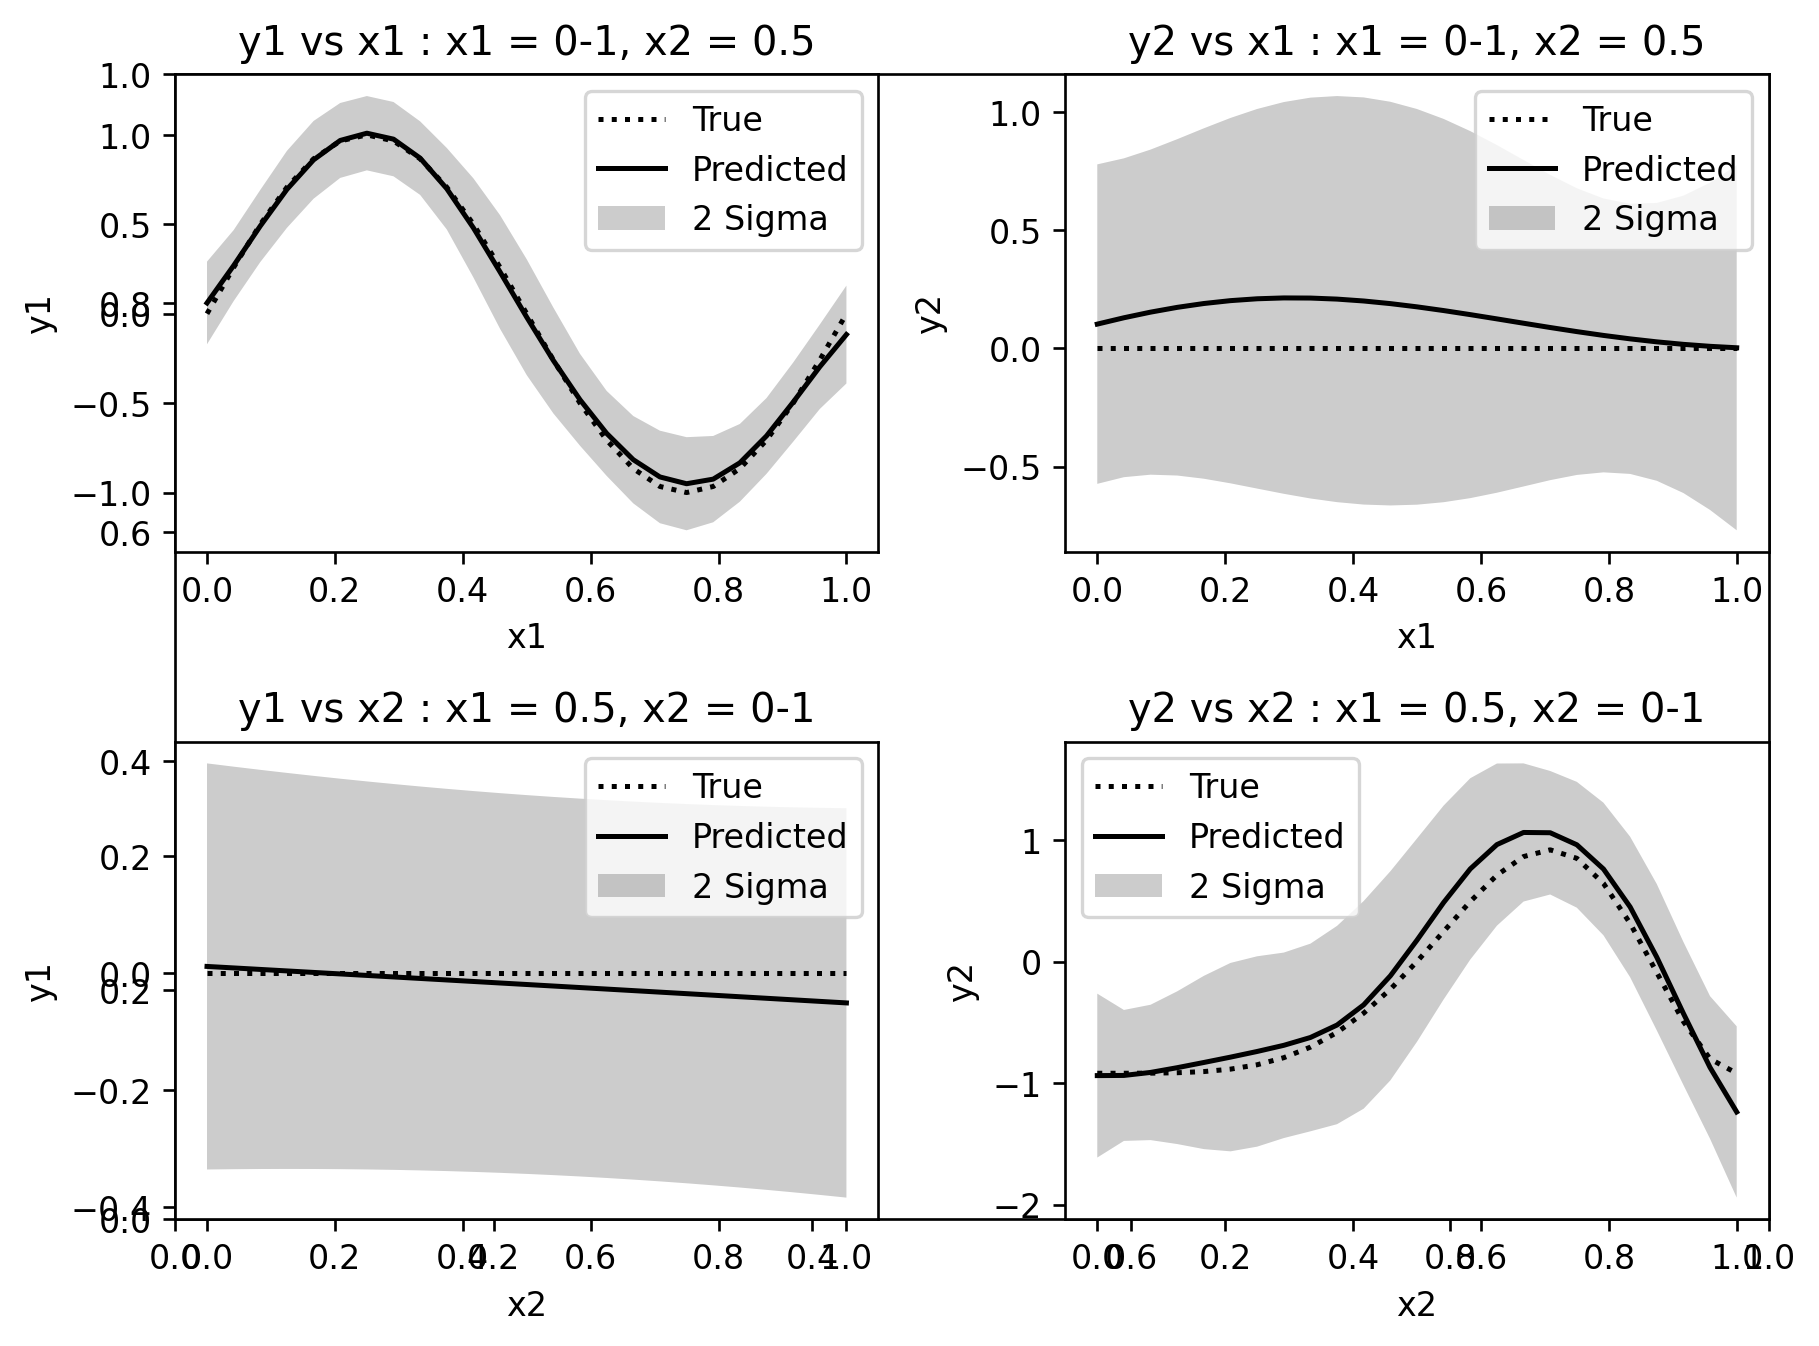

In [4]:
# import os
import torch
# import tqdm
import math
import gpytorch
# from torch.nn import Linear
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution \
    # , LMCVariationalStrategy
from gpytorch.distributions import MultivariateNormal
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL, VariationalELBO
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from matplotlib import pyplot as plt

## RUN PARAMETER

smoke_test = False

training_pts = 20

## TRAINING DATA

train_x = torch.stack([torch.rand(training_pts), torch.rand(training_pts)],-1)

train_y = torch.stack([
    torch.sin((2 * math.pi)*train_x[:,0]),
    -2.5*torch.cos((2 * math.pi)*train_x[:,1]**2)*torch.exp(-2*train_x[:,0]),
    ],-1)

num_tasks = train_y.size(-1)

## GENERATING GP SIMILAR TO THAT IN TUTORIAL (not deep)

class DGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, linear_mean=True):
        inducing_points = torch.randn(output_dims, num_inducing, input_dims)
        batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy, input_dims, output_dims)
        self.mean_module = LinearMean(input_dims) if linear_mean else ConstantMean()
        self.covar_module = ScaleKernel(
            MaternKernel(nu=2.5, batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

class MultitaskDeepGP(DeepGP):
    def __init__(self, train_x_shape):
        gp_layer = DGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_tasks,
            linear_mean=True
        )

        super().__init__()

        self.gp_layer = gp_layer

        # We're going to use a ultitask likelihood instead of the standard GaussianLikelihood
        self.likelihood = MultitaskGaussianLikelihood(num_tasks=num_tasks)

    def forward(self, inputs):
        output = self.gp_layer(inputs)
        return output

    def predict(self, test_x):
        with torch.no_grad():

            # The output of the model is a multitask MVN, where both the data points
            # and the tasks are jointly distributed
            # To compute the marginal predictive NLL of each data point,
            # we will call `to_data_independent_dist`,
            # which removes the data cross-covariance terms from the distribution.
            preds = model.likelihood(model(test_x)).to_data_independent_dist()

        return preds.mean.mean(0), preds.variance.mean(0)

## TRAINING MODEL

model = MultitaskDeepGP(train_x.shape)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, num_data=train_y.size(0)))

num_epochs = 10 if smoke_test else 200

for i in range(num_epochs):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
## TESTING ON DATA WHERE x1 = 0-1, x2 = 0.5
    
test_x = torch.stack([torch.linspace(0, 1, 25), torch.ones(25)*0.5],-1)   
test_y = torch.stack([
    torch.sin((2 * math.pi)*test_x[:,0]),
    -2.5*torch.cos((2 * math.pi)*test_x[:,1]**2)*torch.exp(-2*test_x[:,0]),
    ],-1)
    
model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    mean, var = model.predict(test_x)
    lower = mean - 2 * var.sqrt()
    upper = mean + 2 * var.sqrt()

# Plot results
fig, ax = plt.subplots(figsize=(8, 6), dpi=240)

plt.subplot(2,2,1)
plt.title('y1 vs x1 : x1 = 0-1, x2 = 0.5')
plt.plot(test_x[:,0].numpy(), test_y[:,0].numpy(), ':k')
plt.plot(test_x[:,0].numpy(), mean[:,0].numpy(), 'k')
plt.fill_between(test_x[:,0].numpy(), lower[:,0].numpy(), upper[:,0].numpy(), facecolor='k', alpha=0.2)
plt.xlabel('x1')
plt.ylabel('y1')
plt.legend(['True','Predicted','2 Sigma'])

plt.subplot(2,2,2)
plt.title('y2 vs x1 : x1 = 0-1, x2 = 0.5')
plt.plot(test_x[:,0].numpy(), test_y[:,1].numpy(), ':k')
plt.plot(test_x[:,0].numpy(), mean[:,1].numpy(), 'k')
plt.fill_between(test_x[:,0].numpy(), lower[:,1].numpy(), upper[:,1].numpy(), facecolor='k', alpha=0.2)
plt.xlabel('x1')
plt.ylabel('y2')
plt.legend(['True','Predicted','2 Sigma'])

## TESTING ON DATA WHERE x1 = 0.5, x2 = 0-1

test_x = torch.stack([torch.ones(25)*0.5, torch.linspace(0, 1, 25)],-1)
test_y = torch.stack([
    torch.sin((2 * math.pi)*test_x[:,0]),
    -2.5*torch.cos((2 * math.pi)*test_x[:,1]**2)*torch.exp(-2*test_x[:,0]),
    ],-1)

model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    mean, var = model.predict(test_x)
    lower = mean - 2 * var.sqrt()
    upper = mean + 2 * var.sqrt()

plt.subplot(2,2,3)
plt.title('y1 vs x2 : x1 = 0.5, x2 = 0-1')
plt.plot(test_x[:,1].numpy(), test_y[:,0].numpy(), ':k')
plt.plot(test_x[:,1].numpy(), mean[:,0].numpy(), 'k')
plt.fill_between(test_x[:,1].numpy(), lower[:,0].numpy(), upper[:,0].numpy(), facecolor='k', alpha=0.2)
plt.xlabel('x2')
plt.ylabel('y1')
plt.legend(['True','Predicted','2 Sigma'])

plt.subplot(2,2,4)
plt.title('y2 vs x2 : x1 = 0.5, x2 = 0-1')
plt.plot(test_x[:,1].numpy(), test_y[:,1].numpy(), ':k')
plt.plot(test_x[:,1].numpy(), mean[:,1].numpy(), 'k')
plt.fill_between(test_x[:,1].numpy(), lower[:,1].numpy(), upper[:,1].numpy(), facecolor='k', alpha=0.2)
plt.xlabel('x2')
plt.ylabel('y2')
plt.legend(['True','Predicted','2 Sigma'])

plt.tight_layout()